# Natural Language Processing project - Emotional Dialogues dataset (EDOS)

#### **Contributors to the project**:
- Tommaso Capacci, person code: 10654230
- Gabriele Ginestroni, person code: 10687747
- Simone Giampà, person code: 10659184
- Francesco Leone, person code: 10659809

The following work relates to the EDOS dataset containing over 1M dialogues extracted from movie scripts, in english

Import libraries needed for this project

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import TFAutoModelForSequenceClassification
from transformers import AdamWeightDecay
from datasets import Dataset, DatasetDict

import tensorflow as tf
from tensorflow.keras.optimizers.schedules import PolynomialDecay
print(tf.__version__)
print(tf.config.list_physical_devices())


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

2.12.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Load dataset: approximately 1M sentences (utterances)

In [2]:

dataset = pd.read_csv('../input/edos-1m/EDOS 1M.csv')

X,y = dataset["uttr"], dataset["eb+_emot"]

classes = np.sort(y.unique())
print(classes)

['acknowledging' 'afraid' 'agreeing' 'angry' 'annoyed' 'anticipating'
 'anxious' 'apprehensive' 'ashamed' 'caring' 'confident' 'consoling'
 'content' 'devastated' 'disappointed' 'disgusted' 'embarrassed'
 'encouraging' 'excited' 'faithful' 'furious' 'grateful' 'guilty'
 'hopeful' 'impressed' 'jealous' 'joyful' 'lonely' 'neutral' 'nostalgic'
 'prepared' 'proud' 'questioning' 'sad' 'sentimental' 'suggesting'
 'surprised' 'sympathizing' 'terrified' 'trusting' 'wishing']


Structure of the first rows in this dataset. The dataset is structured to have many dialogues with many turns. Each dialogue has a single id but can have more than 2 turn. The column _eb+_emot_ describes the emotion associated to that utterance. _Label confidence_, instead, represents the label confidence of the classifier used to build the provided dataset

In [ ]:
dataset.head()

,dialogue_id,turn,uttr,eb+_emot,label_confidence
0,97,1,You moron ! What fool washes diapers by the we...,angry,0.437522
1,97,2,You useless fool !,furious,0.731564
2,99,1,How dare you sleep !,furious,0.605636
3,99,2,Up ! Go and clean the house .,prepared,0.650449
4,100,1,Clean the kitchen .,prepared,0.742187


# Preliminary dataset analysis

Plot classes distribution. As the plot shows, there is a clear class imbalance, there the class "questioning" is by far the most common one

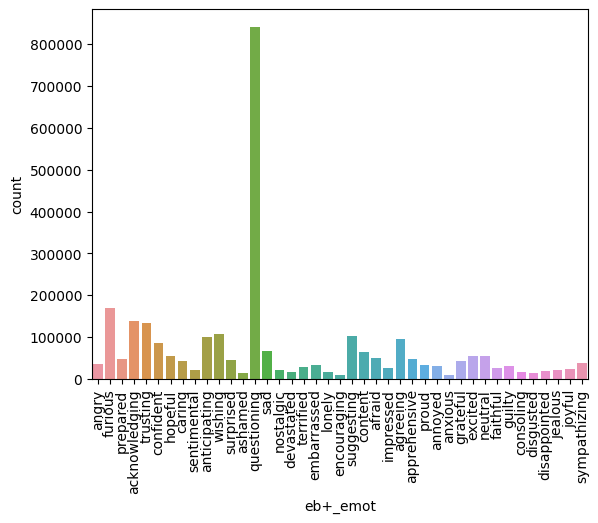

In [ ]:
# plot classes distribution
sns.countplot(x='eb+_emot', data=dataset)
# write class names vertically
plt.xticks(rotation=90)
plt.show()


Let's compute the statistics for the most frequent class (questioning). The percentage defines the accuracy of a baseline model that simply predicts the majority class.

In [79]:
#get explicit classes counts
counts = pd.get_dummies(y).sum()
#printing statistics for most present class (Questioning)
label2id = dict(zip(classes, range(len(classes))))
print("Questioning count: "+str(counts[label2id["questioning"]]))
print(f"Questioning percentage: {counts[label2id['questioning']]/len(y):.3f}")

Questioning count: 841556
Questioning percentage: 0.297


## Vocabulary statistics

Let's analyze the vocabulary and the set of words for all the utterances

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk import FreqDist
import string
import re

Number of words present in the dataset

In [ ]:
doc = ", ".join(dataset["uttr"])
words = doc.split()
len(words)

39469825

Number of unique words (lowercase letters)

In [ ]:
lowercase_doc = doc.lower()
words = lowercase_doc.split()
vocab = set(words)
len(vocab)

277024

Strip the punctuation from the dataset

In [ ]:
regex = '[' + string.punctuation + ']'
doc2_nopunctuation = re.sub(regex,'',lowercase_doc)
print(doc2_nopunctuation[:1000])

you moron  what fool washes diapers by the well  you useless fool  how dare you sleep  up  go and clean the house  clean the kitchen  i cleaned the kitchen  ma am  your name means to trust  it also means truth  and endurance  or it could be god  you were given a great name  you d better live up to it  i ll go home in the spring once the snow melts  listen  no matter how tough it gets i wouldn t bring shame to you and your dad  i promise i won t  your medicine  open your mouth  granny  don t spill it  granny  oshin  brandon said he s headed down to galway  craking  galway  it s the same thing  he s really heading down there  hi there  welcome to the stockroom  i don t really work here  i ve never even been to a store like this  don t get me wrong  i m not a prude  i like sex  shut up bitch  show us the butt plugs  butt plugs  aisle three i think  sorry  shengqi  my dad s present is more important than your pretend promise to your imaginary daughter  she s real  everything i ve told you 

Let's find the most common words present in this dataset

In [ ]:
words = doc2_nopunctuation.lower().split()
sorted_vocab = sorted(set(words))

# 20 most common word
counts = nltk.Counter(words)
counts.most_common(20)

[('you', 1534393),
 ('i', 1204942),
 ('the', 917180),
 ('to', 749409),
 ('s', 621568),
 ('it', 587412),
 ('a', 579725),
 ('t', 434283),
 ('that', 395960),
 ('and', 363961),
 ('is', 356225),
 ('what', 352648),
 ('of', 342576),
 ('me', 325439),
 ('we', 303621),
 ('in', 298627),
 ('this', 268911),
 ('are', 244647),
 ('for', 241906),
 ('do', 235273)]

... excluding the stop-words from the count

In [ ]:
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))
counts_nostopwords = FreqDist(w for w in words if w not in stopwords)
most_common_words = counts_nostopwords.most_common(20)

#20 most common words excluding stop-words
print(most_common_words)

[('know', 166768), ('get', 141445), ('go', 128540), ('like', 127309), ('come', 112337), ('right', 110645), ('want', 100195), ('one', 93542), ('good', 90990), ('see', 87898), ('think', 85531), ('got', 82247), ('well', 81755), ('going', 76447), ('let', 75508), ('yes', 74771), ('yeah', 69091), ('back', 67175), ('take', 66526), ('us', 66092)]


## Some statistics about the utterances and conversations

In [18]:
#conversations count
conv_count = dataset['dialogue_id'].nunique()
print("Dialogues count: "+str(int(conv_count)))
#utterances count
print("Utterances count: "+str(int(len(dataset))))
#average utterance length
word_counts = dataset["uttr"].apply(lambda x: len(str(x).split()))
print("Average utterance length: "+str(word_counts.mean()))
#average utterance vocabulary length
unique_word_counts = dataset["uttr"].apply(lambda x: len(set(str(x).split())))
print("Average utterance vocabulary size: "+str(unique_word_counts.mean()))

Dialogues count: 1000000
Utterances count: 2829426
Average utterance length: 13.949764015740294
Average utterance vocabulary size: 12.124398376207754


In [14]:
average_conversation_length = dataset.groupby('dialogue_id').count().mean()['uttr']
min_conversation_length = dataset.groupby('dialogue_id').count().min()['uttr']
max_conversation_length = dataset.groupby('dialogue_id').count().max()['uttr']

print('average_conversation_length: ', average_conversation_length)
print('min_conversation_length: ', min_conversation_length)
print('max_conversation_length: ', max_conversation_length)

df_max = dataset[dataset['turn'] == max_conversation_length]
print(df_max)
df_longest_dialogue = dataset[dataset['dialogue_id'] == 8134554]
df_longest_dialogue.head(15)

average_conversation_length:  2.829426
min_conversation_length:  2
max_conversation_length:  14
         dialogue_id  turn                     uttr eb+_emot  label_confidence
2229312      8134554    14  lots . up to his eyes .  annoyed          0.450749


,dialogue_id,turn,uttr,eb+_emot,label_confidence
2229299,8134554,1,so how do you know ... shark ?,questioning,0.979632
2229300,8134554,2,shark know i .,confident,0.834527
2229301,8134554,3,you hired me through him ?,questioning,0.924575
2229302,8134554,4,aye .,agreeing,0.889659
2229303,8134554,5,mmm . good news for mouse. he 's hired .,excited,0.653723
2229304,8134554,6,what 's the job ?,questioning,0.981177
2229305,8134554,7,golden joe .,acknowledging,0.495648
2229306,8134554,8,golden ?,acknowledging,0.506589
2229307,8134554,9,no way .,neutral,0.697645
2229308,8134554,10,way . curds and whey .,annoyed,0.668778


# SVM classifier on bag of terms

Training a SVM (support vector machine) to classify the utterances, using a bag of terms embedding

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier

In [7]:
# train, validation and test split
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.2, stratify=y)

print("train size: ", len(train_X))
print("validation size: ", len(valid_X))

train size:  2263540

validation size:  565886


Using count vectorizer we represent each utterance with a vector of word occurrencies.

In [8]:
# vectorize the text using word count
vectorizer = CountVectorizer(min_df=5, stop_words='english')
vectorizer.fit(train_X)
print("Vocabulary length: " + str(len(vectorizer.get_feature_names_out())))

train_X_vector = vectorizer.transform(train_X)
valid_X_vector = vectorizer.transform(valid_X)

Vocabulary length: 52112


After applying the count vectorizer to the dataset (by fitting it to the training set and applying the transformation computed to the validation set), we can use the SVM. The SVM is obtained by using a simple SGDClassifier (stochastic gradient descent) using the hinge loss function. This loss function computes the classification label based on a maximum margin from the decision boundary.

In [ ]:
# going for SVMs since they're usually reliable with high dimensional data
model = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-5, max_iter=5, tol=None)
model.fit(train_X_vector, train_y)

SGDClassifier(alpha=1e-05, max_iter=5, tol=None)

Test the model on the validation dataset. We can see that the performance is poor but not terrible. Of course more advanced models would perform much better that this. We can consider this model as a baseline used for comparison.

In [ ]:
# validate the model
pred_y = model.predict(valid_X_vector)

print('Results for the basic SVM classifier:')
print(classification_report(valid_y, pred_y, target_names=classes))

Results for the basic SVM classifier:

               precision    recall  f1-score   support



        angry       0.47      0.27      0.34     41449

      furious       0.57      0.58      0.57     14785

     prepared       0.38      0.19      0.26     28969

acknowledging       0.43      0.16      0.23     10477

     trusting       0.33      0.16      0.21      9022

    confident       0.50      0.43      0.46     30130

      hopeful       0.51      0.31      0.39      2573

       caring       0.27      0.15      0.19     14018

  sentimental       0.31      0.21      0.25      4439

 anticipating       0.28      0.12      0.16     12842

      wishing       0.37      0.16      0.22     25475

    surprised       0.21      0.21      0.21      5177

      ashamed       0.50      0.37      0.43     19371

  questioning       0.34      0.18      0.24      5262

          sad       0.38      0.26      0.31      5489

    nostalgic       0.55      0.39      0.46      4521

   deva

The SVM has relatively poor performance, in fact the overall accuracy of the model is 50% in the validation set. This result was expected

# Semantic Similarity

Another interesting task is to compute the semantic similarities among the embeddings of the classes, in order to find out if the average embeddings of all utterances for a single class is similar to other classes.

In [5]:
from sklearn.manifold import TSNE
from tqdm import tqdm
import plotly.express as px
import torch
#!pip install -U sentence_transformers
from sentence_transformers import SentenceTransformer, util

Split training set and validation set

In [6]:
dataset_copy_reduced = dataset.sample(n=int(len(dataset)*0.5), ignore_index=True)
print(dataset_copy_reduced.head(5))

indexes_mask = np.arange(len(dataset_copy_reduced))
data_ind, test_ind = train_test_split(indexes_mask, test_size=0.3, stratify=dataset_copy_reduced['eb+_emot'])
data_X = dataset_copy_reduced['uttr'][data_ind]
data_y = dataset_copy_reduced['eb+_emot'][data_ind].tolist()
test_X = dataset_copy_reduced['uttr'][test_ind]
test_y = dataset_copy_reduced['eb+_emot'][test_ind]

# redifine valid_y in order to contain integers
test_y = np.argmax(pd.get_dummies(test_y).to_numpy(), axis=1)

print("Size of the data the will be used to compute the average class embeddings: ", len(data_X))
print("Test size: ", len(test_X))

   dialogue_id  turn                                               uttr  \
0      4396505     2  If something happens ... you 'll come right aw...   
1      4218448     1                        You must tell them ! What ?   
2       963146     2                         I am pulling them up now .   
3       699396     2                                          Big day !   
4      8648095     2      In college , yeah . We oughta play sometime .   

      eb+_emot  label_confidence  
0  questioning          0.784438  
1  questioning          0.840779  
2     prepared          0.879646  
3      excited          0.729099  
4   suggesting          0.587219  
Size of the data the will be used to compute the average class embeddings:  990299
Test size:  424414


Function to compute the accuracy of the top-3 guesses

In [8]:
# support function to compute top-k accuracy
def top_k_accuracy(true_y, pred_y, k):
    # Get the top k predictions for each sample in the validation dataset
    pred_y_top_k = np.argsort(pred_y, axis=1)[:, -k:]

    # Get the ground truth labels for the validation dataset
    true_labels = np.asarray(true_y)

    # Compute top k accuracy
    top_k_accuracy = np.mean(np.any(pred_y_top_k == true_labels.reshape(true_labels.shape[0], 1), axis=1))
    return f"Top-{k} accuracy: " + str(top_k_accuracy)

Using T-SNE we can compute a lower-dimensional visual representation (in 3D) of the average embedding per class

In [100]:
# support function to print TSNE representation
tsne = TSNE(n_components=3, n_iter=250)
colors = [ f'rgb({int(color[0]*255)},{int(color[1]*255)},{int(color[2]*255)})' for color in sns.color_palette(None, len(classes))]
color_discrete_map = dict(zip(classes, colors))

def plot_tsne(tsne_embedding, title=None):
    x, y, z = np.transpose(tsne_embedding)
    fig = px.scatter_3d(x=x, y=y, z=z, title=title, text=classes, color=classes, color_discrete_map=color_discrete_map)
    fig.update_traces(marker=dict(size=3,line=dict(width=2)))
    fig.show()

Using Sentence Transformer and a model based on RoBERTa, we can encode the utterances to produce the embeddings

In [7]:
model = SentenceTransformer('all-distilroberta-v1')

# get validation embeddings
X_embeddings = model.encode(data_X.to_numpy(), convert_to_tensor=True).cpu()
X_embeddings.size()

Batches:   0%|          | 0/30947 [00:00<?, ?it/s]

torch.Size([990299, 768])

## Weighted Average class embeddings

Now we compute the embeddings for all utterances

In [102]:
# get test embeddings
test_embeddings = model.encode(test_X.to_numpy(), convert_to_tensor=True).cpu()
test_embeddings.size()

Batches:   0%|          | 0/13263 [00:00<?, ?it/s]

torch.Size([424414, 768])

We are now computing the weighted average class embeddings. The approach consists in weighting each utterance embedding using its _label confidence_ attribute provided in the dataset. In this way we should get a robust average class embedding. 

In [103]:
confidences = dataset["label_confidence"]
confidences_X = confidences[data_ind].tolist()
# get mean embedding per label
class_embeddings = []
for i in tqdm(range(len(classes))):
    count = 0
    tmp = np.zeros((X_embeddings.shape[1]))
    for j in range(len(X_embeddings)):
        if data_y[j] == classes[i]:
            count += confidences_X[i]
            tmp = np.add(X_embeddings[j].cpu().numpy() * confidences_X[i], tmp)
    class_embeddings.append(tmp/count)

100%|██████████| 41/41 [00:35<00:00,  1.16it/s]


The computed embeddings vector is a vector of shape (41, 768), where 41 is the number of classes, and 768 is the size of the embedding vector used by the model Distill-RoBERTa-v1

In [104]:
class_embeddings = np.array(class_embeddings, dtype=np.float32)
class_embeddings.shape

(41, 768)

3D plot of the class embeddings using T-SNE method

In [105]:
# get tsne representation of label embeddings
tsne_embedding = tsne.fit_transform(class_embeddings)
plot_tsne(tsne_embedding, title="Class embeddings")

From the previous plot, we observe that T-SNE is not able to equally separate all the class embeddings, so many embeddings are similar. Let's now explore if this is true by plotting the cosine similarities among the class vectors.

In [106]:
# compute embedding similarities
similarity_matrix = torch.vstack(
    [util.cos_sim(embedding, class_embeddings)[0] for embedding in class_embeddings]
)
similarity_matrix.shape

torch.Size([41, 41])

Visualize the similarities among class embedding vectors in a matrix.
The brighter the colour the higher the similarity.

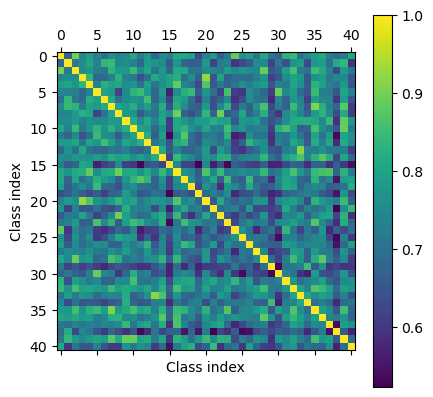

In [107]:
plt.matshow(similarity_matrix.cpu().numpy())
plt.xlabel('Class index')
plt.ylabel('Class index')
plt.colorbar()
plt.show()

The matrix plot confirms that, using the cosine similarity function, the majority of classes has similar embeddings. For this reason, we think that using top-3 accuracy for the evaluation of the models trained on this dataset would provide a better overview of the real performances. We also have to take into account that most of the dataset labels do not represent a ground truth, as they are automatically generated and provided with a label confidence. We will further explore this by performing the elbow method over the utterance embeddings.

We now perform a simple prediction (of the test set) based on cosine similarity with respect to the average class embedding

In [108]:
# compute predictions
sim_matrix = torch.vstack(
    [util.cos_sim(embedding, class_embeddings)[0] for embedding in test_embeddings]
)
sim_matrix.shape

# validate the model
test_preds = sim_matrix.cpu().numpy()

print('Results for Semantic Similarity classification with Labels embeddings:')
print(classification_report(test_y, np.argmax(test_preds, axis=1), target_names=classes))
print(top_k_accuracy(test_y, test_preds, 3))


Results for Semantic Similarity classification with Labels embeddings:
               precision    recall  f1-score   support

acknowledging       0.41      0.30      0.35     20761
       afraid       0.43      0.46      0.44      7416
     agreeing       0.33      0.31      0.32     14508
        angry       0.27      0.39      0.32      5231
      annoyed       0.18      0.41      0.25      4496
 anticipating       0.40      0.48      0.43     15065
      anxious       0.13      0.52      0.21      1279
 apprehensive       0.28      0.26      0.27      7036
      ashamed       0.13      0.37      0.20      2196
       caring       0.21      0.39      0.28      6422
    confident       0.35      0.31      0.32     12733
    consoling       0.17      0.47      0.25      2612
      content       0.37      0.41      0.39      9676
   devastated       0.17      0.48      0.25      2632
 disappointed       0.14      0.39      0.21      2733
    disgusted       0.18      0.67      0.29    

The accuracy is as expected lower (but similar) than the SVM baseline model. However, this simple classifier is better than random guessing (1/41 -> 2.4%) and predicting the most frequent class (29.7%)

# Clustering on utterance embeddings

We check now how many clusters the elbow method is finding over the utterance embeddings

In [8]:
from sklearn.cluster import MiniBatchKMeans
from yellowbrick.cluster import KElbowVisualizer

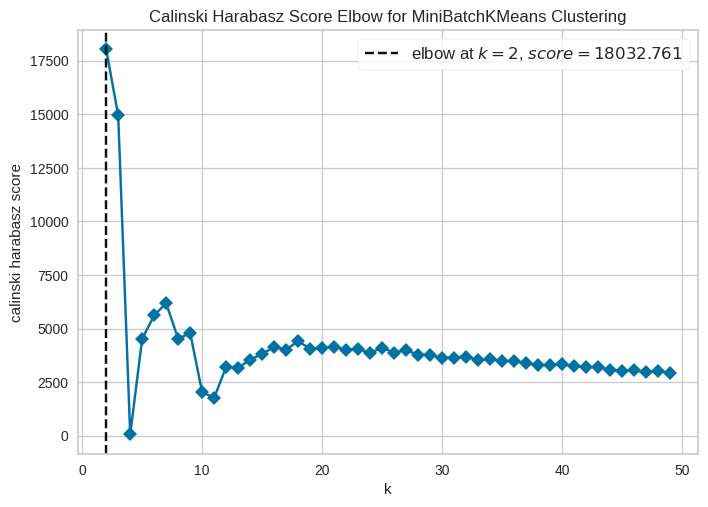

<Axes: title={'center': 'Calinski Harabasz Score Elbow for MiniBatchKMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [9]:
# Instantiate the clustering model and visualizer
model = MiniBatchKMeans(batch_size=16, n_init="auto", random_state=16)
visualizer = KElbowVisualizer(
    model, k=(2,50), metric='calinski_harabasz', timings=False
)

visualizer.fit(X_embeddings)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

The elbow method applied over the utterance embeddings with KMeans find a low number of clusters, suggesting that many utterances are similar. An alternative would have been applying the same technique over the utterance vectors provided by CountVectorizer, but we decided not to proceed on this as we expected worse results caused by the higher dimensionality and the size of the dataset.

# Training Natural Language Models

In this section we train natural language models based on the BERT model in order to compute predictions of the class to which a utterance belongs to. We use many approaches in order to maximize the accuracy of the models. We also compare their performance based on the dataset on which they are trained on.

In [ ]:
# train, validation and test split
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.3, stratify=y)

print("train size: ", len(train_X))
print("validation size: ", len(valid_X))

train size:  990299

validation size:  424414


Compute transformation between ids and labels and vice versa

In [ ]:

# map expected ids to their labels and viceversa
id2label = dict(zip(range(len(classes)), classes))
label2id = dict(zip(classes, range(len(classes))))
print(id2label)

{0: 'acknowledging', 1: 'afraid', 2: 'agreeing', 3: 'angry', 4: 'annoyed', 5: 'anticipating', 6: 'anxious', 7: 'apprehensive', 8: 'ashamed', 9: 'caring', 10: 'confident', 11: 'consoling', 12: 'content', 13: 'devastated', 14: 'disappointed', 15: 'disgusted', 16: 'embarrassed', 17: 'encouraging', 18: 'excited', 19: 'faithful', 20: 'furious', 21: 'grateful', 22: 'guilty', 23: 'hopeful', 24: 'impressed', 25: 'jealous', 26: 'joyful', 27: 'lonely', 28: 'neutral', 29: 'nostalgic', 30: 'prepared', 31: 'proud', 32: 'questioning', 33: 'sad', 34: 'sentimental', 35: 'suggesting', 36: 'surprised', 37: 'sympathizing', 38: 'terrified', 39: 'trusting', 40: 'wishing'}


Function for computing top-k accuracy of a model predicting the classes

In [ ]:
# support function to compute top-k accuracy
def top_k_accuracy(true_y, pred_y, k):
    # Get the top k predictions for each sample in the validation dataset
    pred_y_top_k = np.argsort(pred_y, axis=1)[:, -k:]

    # Get the ground truth labels for the validation dataset
    true_labels = np.asarray(true_y)

    # Compute top k accuracy
    top_k_accuracy = np.mean(np.any(pred_y_top_k == true_labels.reshape(true_labels.shape[0], 1), axis=1))
    return f"Top-{k} accuracy: " + str(top_k_accuracy)

Splitting training set and validation set

In [ ]:
# building the datasets
train_data = Dataset.from_pandas(pd.DataFrame({"text": train_X, "label": np.argmax(pd.get_dummies(train_y).to_numpy(), axis=1)}), preserve_index=False)
valid_data = Dataset.from_pandas(pd.DataFrame({"text": valid_X, "label": np.argmax(pd.get_dummies(valid_y).to_numpy(), axis=1)}), preserve_index=False)

# shuffling is performed at the previous operation -> we need to redefine valid_y
valid_y = valid_data['label']

data = DatasetDict()
data['train'] = train_data
data['validation'] = valid_data

print(data['train'][0])
data

{'text': "Hey . Hey . How 'd it go at the label ? Uh ... I think I fixed it temporarily . Now I gotta fix my sister .", 'label': 11}


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 990299
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 424414
    })
})

## Distill-Bert uncased

We first use the model Distill-BERT (base and uncased version) to compute the predictions. This model was initially trained by freezing the top layers and leaving unfreezed only the final classifier layer. The performance was about 63% in the validation set after 3 epochs, and taking 75 minutes per epoch. We realized that training the entire model (about 68M parameters) was taking about 2 hours per epoch but the accuracy was also much higher.

All trainings were completed using the Nvidia P100 GPU on Kaggle.

In [ ]:
# model metadata
model_name = "distilbert-base-uncased"


Autotokenizer used to compute the tokens for each word in all utterances

In [ ]:
# load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# tokenize the data
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)
tokenized_data = data.map(preprocess_function, batched=True)

print(tokenized_data["train"][0])
tokenized_data

  0%|          | 0/991 [00:00<?, ?ba/s]

  0%|          | 0/425 [00:00<?, ?ba/s]

{'text': "Hey . Hey . How 'd it go at the label ? Uh ... I think I fixed it temporarily . Now I gotta fix my sister .", 'label': 11, 'input_ids': [101, 4931, 1012, 4931, 1012, 2129, 1005, 1040, 2009, 2175, 2012, 1996, 3830, 1029, 7910, 1012, 1012, 1012, 1045, 2228, 1045, 4964, 2009, 8184, 1012, 2085, 1045, 10657, 8081, 2026, 2905, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 990299
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 424414
    })
})

Set up hyper parameters and the datasets for the model before training

In [ ]:
# metadata
batch_size = 16
num_epochs = 3
patience = 3
only_fine_tune = False

# convert datasets to a suitable format for tensorflow
data_collator = DataCollatorWithPadding(tokenizer, return_tensors="tf")

tf_train_dataset = tokenized_data["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "label"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)

tf_validation_dataset = tokenized_data["validation"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "label"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)


Mirrored strategy is used to exploit the Nvidia SLI Tesla T4 X2 on Kaggle to have parallel computation and faster training time. The loss function is sparse categorical cross entropy because we are classifying 41 classes. We use Adam optimizer with a weight decay and a polynomial decay for the learning rate, in order to have better optimized training.

In [ ]:

# create optimizer and learning rate scheduler
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=2e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)
opt = AdamWeightDecay(learning_rate=lr_scheduler,
                      weight_decay_rate=0.01)

# from within the selected parallelization strategy...
with mirrored_strategy.scope():
    
    # ...load the model...
    model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(classes), id2label=id2label, label2id=label2id)
    if only_fine_tune:
        for i in range(1):
            model.layers[i].trainable = False
    
    # ...and compile it
    model.compile(optimizer=opt,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=["accuracy"])

model.summary()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_transform', 'activation_13', 'vocab_layer_norm']

- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).

- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).

Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_19']

You should probably TRAIN this model on a down-stream task to be able to u

Model: "tf_distil_bert_for_sequence_classification"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 distilbert (TFDistilBertMai  multiple                 66362880  

 nLayer)                                                         

                                                                 

 pre_classifier (Dense)      multiple                  590592    

                                                                 

 classifier (Dense)          multiple                  31529     

                                                                 

 dropout_19 (Dropout)        multiple                  0         

                                                                 


Total params: 66,985,001

Trainable params: 66,985,001

Non-trainable params: 0

_________________________________________________________________


By training the entire model and all 67M parameters, we were able to achieve a stunning validation accuracy of 84% after just 3 epochs of training.

In [ ]:
# training
history = model.fit(
          tf_train_dataset,
          validation_data=tf_validation_dataset,
          epochs=num_epochs,                                  
          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=patience, restore_best_weights=True)]
)

Epoch 1/3

61893/61893 [==============================] - 5630s 91ms/step - loss: 0.7172 - accuracy: 0.7734 - val_loss: 0.5501 - val_accuracy: 0.8169

Epoch 2/3

61893/61893 [==============================] - 5630s 91ms/step - loss: 0.4444 - accuracy: 0.8505 - val_loss: 0.4936 - val_accuracy: 0.8365

Epoch 3/3

61893/61893 [==============================] - 5609s 91ms/step - loss: 0.3042 - accuracy: 0.8968 - val_loss: 0.4932 - val_accuracy: 0.8428


Predictions with BERT and all the statistics are shown here. The top-3 accuracy is 97.3%, which is incredibly high

In [ ]:
# validate the model -> accuracy should correspond to final val_accuracy
bert_y = model.predict(tf_validation_dataset)["logits"]

print('Results for BERT-based classifier:')
print(classification_report(valid_y, np.argmax(bert_y, axis=1), target_names=classes))
print(top_k_accuracy(valid_y, bert_y, 3))

26526/26526 [==============================] - 809s 30ms/step

Results for BERT-based classifier:

               precision    recall  f1-score   support



acknowledging       0.78      0.79      0.78     20705

       afraid       0.80      0.82      0.81      7405

     agreeing       0.79      0.76      0.78     14512

        angry       0.71      0.67      0.69      5306

      annoyed       0.68      0.67      0.68      4537

 anticipating       0.82      0.83      0.82     15120

      anxious       0.72      0.69      0.70      1306

 apprehensive       0.79      0.77      0.78      6976

      ashamed       0.70      0.62      0.66      2246

       caring       0.76      0.77      0.77      6412

    confident       0.78      0.77      0.77     12818

    consoling       0.77      0.73      0.75      2579

      content       0.84      0.85      0.84      9702

   devastated       0.70      0.66      0.68      2616

 disappointed       0.75      0.72      0.74      2729

   

These results, including the 97.4% of top-3 accuracy, seem confirming what we've observed with class embeddings similarities. A top-3 accuracy value that is this high can be due to the fact that some classes are similar to others, and the model can sometimes mistake them. This means that the model needs maximum 3 guesses to correctly identify the class for a certain utterance 97% of the times.

## Multi-utterance classification models

Dataset creation for models trained using a multi-utterance approach. We structure the new dataset in order to obtain pairs of utterances, and the model exploits information from the 2 of them in order to classify one utterance. This method serves for increasing the model prediction accuracy, by adding contextual information that can be useful to better understand the meaning of the sentences.

We create 2 versions of the dataset, containing consecutive pairs of utterances extracted from the same dialogue (identified with its id). The consecutive pairs of utterances are obtained by multiple turns from a single dialogue (conversation).

The "preceding" one is composed of utterances pairs, where the context is given by the preceding utterance, so the model is trained to classify the second utterance. Instead, the "following" one is a set of pair of utterances where the context is given by the following utterance, so the model is trained to classify the first utterance in the pair.

In [5]:
#preparing the new dataset containing utterances pairs

df = dataset.merge(dataset, on='dialogue_id', how='inner') #self join
#creating auxialiary attributes
df['is_first'] = (df['turn_x'] == 1) & (df['turn_y'] == 1)
df['is_last'] = (df['turn_x'] == df['turn_y']) & (df['turn_y'] == df.groupby('dialogue_id')['turn_y'].transform(max))
#keep only first/last utterances and all the consecutive pairs               
df = df[df['is_first'] | df['is_last'] | (df['turn_x'] == df['turn_y'] - 1)]
#display(df,10) 

#df_preceding will be used to predict the last utterance, given the previous context, if it exists
df_preceding = df[df['is_last'] == 0]
df_preceding = df_preceding[['dialogue_id','turn_x','uttr_x','turn_y','uttr_y','eb+_emot_y','is_first']].rename(columns={'eb+_emot_y': 'label'})
#df_following will be used to predict the first utterance, given the following context, if it exists
df_following = df[df['is_first'] == 0]
df_following = df_following[['dialogue_id','turn_x','uttr_x','turn_y','uttr_y','eb+_emot_x','is_last']].rename(columns={'eb+_emot_x': 'label'})
#replace utterances with empty strings for first and last samples of each conversation
df_preceding.loc[df_preceding['is_first'] == 1, 'uttr_x'] = ""
df_following.loc[df_following['is_last'] == 1, 'uttr_y'] = ""

print("Preceding dataset:")
display(df_preceding,10)
print("Following dataset:")
display(df_following,10)

Preceding dataset:


,dialogue_id,turn_x,uttr_x,turn_y,uttr_y,label,is_first
0,97,1,,1,You moron ! What fool washes diapers by the we...,angry,True
1,97,1,You moron ! What fool washes diapers by the we...,2,You useless fool !,furious,False
4,99,1,,1,How dare you sleep !,furious,True
5,99,1,How dare you sleep !,2,Up ! Go and clean the house .,prepared,False
8,100,1,,1,Clean the kitchen .,prepared,True
...,...,...,...,...,...,...,...
9480212,8820621,2,"Well then , great .",3,This is so stupid . How can I be upset over so...,furious,False
9480218,8820621,3,This is so stupid . How can I be upset over so...,4,It 's negative ?,acknowledging,False
9480224,8820621,4,It 's negative ?,5,"No , it 's positive .",agreeing,False
9480230,8820637,1,,1,Thank God !,grateful,True


10

Following dataset:


,dialogue_id,turn_x,uttr_x,turn_y,uttr_y,label,is_last
1,97,1,You moron ! What fool washes diapers by the we...,2,You useless fool !,angry,False
3,97,2,You useless fool !,2,,furious,True
5,99,1,How dare you sleep !,2,Up ! Go and clean the house .,furious,False
7,99,2,Up ! Go and clean the house .,2,,prepared,True
9,100,1,Clean the kitchen .,2,"I cleaned the kitchen , ma 'am .",prepared,False
...,...,...,...,...,...,...,...
9480218,8820621,3,This is so stupid . How can I be upset over so...,4,It 's negative ?,furious,False
9480224,8820621,4,It 's negative ?,5,"No , it 's positive .",acknowledging,False
9480229,8820621,5,"No , it 's positive .",5,,agreeing,True
9480231,8820637,1,Thank God !,2,So tell me one of your moves .,grateful,False


10

In this notebook, we only show the "preceding" dataset and the models trained on it. Notice though, that the same code applies also for the "following" structured dataset, since the only change required would be to change the value for `df_choice`.

Notice that the `train_test_split()` function is set up in such a way (avoding shuffle and stratified sampling) to ensure that different turns belonging to the same dialogue wouldn't end up in different splits, obtaining a clear subdivision between training set and validation set. This way we are able to prevent information leakage between the training set and validation set.

In [6]:
df_choice = 0 #0 for preceding, 1 for following
dataset_percentage = 0.5

# train, validation and test split
if df_choice == 0:
    df = df_preceding
    samples = int(len(df)*dataset_percentage)
    df = df.sample(n=samples).sort_index() #sort to ensure there is not information leakage between train and test
    train_X, valid_X, train_y, valid_y = train_test_split(df[['dialogue_id','uttr_x','uttr_y','is_first']], df['label'], test_size=0.15, stratify= None, shuffle=False)
else:
    df = df_following
    samples = int(len(df)*dataset_percentage)
    df = df.sample(n=samples).sort_index() #sort to ensure there is not information leakage between train and test
    train_X, valid_X, train_y, valid_y = train_test_split(df[['dialogue_id','uttr_x','uttr_y','is_last']], df['label'], test_size=0.15, stratify= None, shuffle=False)

classes = df['label'].unique()
print(len(classes))

display(train_X,10)
print("train size: ", len(train_X))
print("validation size: ", len(valid_X))

41


,dialogue_id,uttr_x,uttr_y,is_first
4,99,,How dare you sleep !,True
8,100,,Clean the kitchen .,True
9,100,Clean the kitchen .,"I cleaned the kitchen , ma 'am .",False
12,124,,Your name means to trust . It also means truth...,True
13,124,Your name means to trust . It also means truth...,You were given a great name . You 'd better li...,False
...,...,...,...,...
8004541,1269066,,"Let 's see some identification , please ?",True
8004542,1269066,"Let 's see some identification , please ?",What the hell ? What 's the problem ?,False
8004561,1269461,,What are you gonna do with the body ? What am ...,True
8004562,1269461,What are you gonna do with the body ? What am ...,I suppose ... Oakland . With your brother . Ev...,False


10

train size:  1202506
validation size:  212207


HuggingFace dataset creation from pandas and splitting

In [7]:
# building the datasets
if df_choice == 0:
    flag = "is_first"
else:
    flag= "is_last"
train_data = Dataset.from_pandas(pd.DataFrame({"text_1": train_X['uttr_x'],"text_2": train_X['uttr_y'], flag: train_X[flag], "label": np.argmax(pd.get_dummies(train_y).to_numpy(), axis=1)}), preserve_index=False)
valid_data = Dataset.from_pandas(pd.DataFrame({"text_1": valid_X['uttr_x'],"text_2": valid_X['uttr_y'], flag: valid_X[flag], "label": np.argmax(pd.get_dummies(valid_y).to_numpy(), axis=1)}), preserve_index=False)

# shuffling is performed at the previous operation -> we need to redefine valid_y
valid_y = valid_data['label']

data = DatasetDict()
data['train'] = train_data
data['validation'] = valid_data

print(data['train'][0])
data

{'text_1': '', 'text_2': 'How dare you sleep !', 'is_first': True, 'label': 20}


DatasetDict({
    train: Dataset({
        features: ['text_1', 'text_2', 'is_first', 'label'],
        num_rows: 1202506
    })
    validation: Dataset({
        features: ['text_1', 'text_2', 'is_first', 'label'],
        num_rows: 212207
    })
})

## Multi-Utterance classification with Distill-BERT model

Training Multi Utterance classification models with Distill-BERT

In [116]:
model_name = "distilbert-base-uncased"
# load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# tokenize the data
def preprocess_function(examples):
    return tokenizer(examples["text_1"],examples["text_2"], truncation=True)

cols = data["train"].column_names
tokenized_data = data.map(preprocess_function, batched=True, remove_columns=["text_1","text_2",flag])

print(tokenized_data["train"][0])
print()
print(tokenized_data)


  0%|          | 0/1203 [00:00<?, ?ba/s]

  0%|          | 0/213 [00:00<?, ?ba/s]

{'label': 20, 'input_ids': [101, 102, 2129, 8108, 2017, 3637, 999, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 1202506
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 212207
    })
})


Visualizing the effects of the tokenizer

In [120]:
vocab_terms = list(tokenizer.vocab.keys())
vocab_index = list(tokenizer.vocab.values())
print("first utterance: " + data["train"][1]["text_1"])
print("second utterance: " + data["train"][1]["text_2"])
print("tokenized:  ", [vocab_terms[vocab_index.index(i)] for i in tokenized_data["train"][1]["input_ids"]])

first utterance: How dare you sleep !
second utterance: Up ! Go and clean the house .
tokenized:   ['[CLS]', 'how', 'dare', 'you', 'sleep', '!', '[SEP]', 'up', '!', 'go', 'and', 'clean', 'the', 'house', '.', '[SEP]']


In [ ]:
# metadata
batch_size = 16
num_epochs = 3
batches_per_epoch = len(tokenized_data["train"]) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)
print("Total train steps: " + str(total_train_steps))
print("Batches per epoch: " + str(batches_per_epoch))

#optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

data_collator = DataCollatorWithPadding(tokenizer, return_tensors="tf")
only_fine_tune = False

# convert datasets to a suitable format for tensorflow
tf_train_dataset = tokenized_data["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "label"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)

tf_validation_dataset = tokenized_data["validation"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "label"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator
)


Same hyperparamters as before

In [ ]:

num_train_steps = len(tf_train_dataset) * num_epochs
print("Number of training steps: " + str(num_train_steps))

lr_scheduler = PolynomialDecay(initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps)

optimizer = Adam(learning_rate=lr_scheduler)

# create callback to save model at the end of each epoch
save_model_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="./models/model_checkpoint",
    save_weights_only=False,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True
)
    
# apply parallel computation on kaggle
#with mirrored_strategy.scope():
    # load the model
model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(classes), id2label=id2label, label2id=label2id)

# leave only the classification layer trainable
if only_fine_tune:
    for i in range(1):
        model.layers[i].trainable = False

model.compile(
    optimizer = optimizer,
    loss = SparseCategoricalCrossentropy(from_logits=True),
    metrics = ["accuracy"]
)

model.summary()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Total train steps: 225468

Batches per epoch: 75156

Number of training steps: 225468


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'vocab_transform', 'activation_13', 'vocab_projector']

- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).

- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).

Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'pre_classifier', 'classifier']

You should probably TRAIN this model on a down-stream task to be able to u

Model: "tf_distil_bert_for_sequence_classification"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 distilbert (TFDistilBertMai  multiple                 66362880  

 nLayer)                                                         

                                                                 

 pre_classifier (Dense)      multiple                  590592    

                                                                 

 classifier (Dense)          multiple                  31529     

                                                                 

 dropout_19 (Dropout)        multiple                  0         

                                                                 


Total params: 66,985,001

Trainable params: 66,985,001

Non-trainable params: 0

_________________________________________________________________


Training the model with all weights (not only the classification head)

In [ ]:
# training
history = model.fit(
          x=tf_train_dataset,
          validation_data=tf_validation_dataset,
          epochs=num_epochs,                        
          callbacks = [save_model_callback]
)

# save the model
model.save_pretrained("./models/model1")


Epoch 1/3

75156/75156 [==============================] - 7295s 97ms/step - loss: 0.7418 - accuracy: 0.7624 - val_loss: 0.5138 - val_accuracy: 0.8254

Epoch 2/3

75156/75156 [==============================] - 7216s 96ms/step - loss: 0.4398 - accuracy: 0.8493 - val_loss: 0.4551 - val_accuracy: 0.8456

Epoch 3/3

75156/75156 [==============================] - 7191s 96ms/step - loss: 0.2377 - accuracy: 0.9171 - val_loss: 0.4584 - val_accuracy: 0.8586


In [ ]:
# validate the model -> accuracy should correspond to final val_accuracy
bert_y = np.argmax(model.predict(tf_validation_dataset)["logits"], axis=1)

print('Results for BERT-based classifier:')
print(classification_report(valid_y, bert_y, target_names=classes))


13263/13263 [==============================] - 451s 34ms/step

Results for BERT-based classifier:

               precision    recall  f1-score   support



      furious       0.81      0.80      0.80     10993

     prepared       0.79      0.82      0.80      3019

acknowledging       0.80      0.79      0.79      8039

     trusting       0.71      0.67      0.69      1853

      hopeful       0.70      0.66      0.68      2077

       caring       0.84      0.84      0.84      6429

  sentimental       0.73      0.72      0.73       562

 anticipating       0.79      0.77      0.78      3383

    surprised       0.67      0.57      0.62       876

          sad       0.76      0.77      0.77      2892

    nostalgic       0.77      0.75      0.76      5487

   devastated       0.79      0.76      0.78      1479

        angry       0.84      0.86      0.85      4822

  embarrassed       0.68      0.65      0.67       901

       lonely       0.76      0.74      0.75      1219

  e

Here the accuracy is 86%, which is higher than the 84% accuracy obtained by the same model trained on single utterances. We can definitely see a small improvement

In [ ]:
# Get the top 3 predictions for each sample in the validation dataset
bert_y = model.predict(tf_validation_dataset)["logits"]
bert_y_top_3 = np.argsort(bert_y, axis=1)[:, -3:]

# Get the ground truth labels for the validation dataset
validation_labels = np.asarray(valid_y)

# Compute top 3 accuracy
top_3_accuracy = np.mean(np.any(bert_y_top_3 == validation_labels.reshape(validation_labels.shape[0], 1), axis=1))
print("Top-3 accuracy: "+str(top_3_accuracy))

13263/13263 [==============================] - 448s 34ms/step

Top-3 accuracy: 0.9790723208942212


Here the top-3 accuracy is 98%, so there is a small increase with respect to the model trained on single utterances

## Multi-utterance with Distill_RoBERTa

Now using another similar model but with more parameters. This model is pre-trained on English text data for the classification of 7 emotions, which is similar to our task. The model was pretrained on a dataset containing emotion labels for texts from Twitter, Reddit, student self-reports, and utterances from TV dialogues.

In [3]:
# model metadata
model_name = "j-hartmann/emotion-english-distilroberta-base"

In [8]:
# load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# tokenize the data
def preprocess_function(examples):
    return tokenizer(examples["text_1"],examples["text_2"], truncation=True)

cols = data["train"].column_names
tokenized_data = data.map(preprocess_function, batched=True, remove_columns=["text_1","text_2",flag])

print(tokenized_data["train"][0])
print()
print(tokenized_data)

  0%|          | 0/1203 [00:00<?, ?ba/s]

  0%|          | 0/213 [00:00<?, ?ba/s]

{'label': 20, 'input_ids': [0, 2, 2, 6179, 19046, 47, 3581, 27785, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 1202506
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 212207
    })
})


In [21]:
vocab_terms = list(tokenizer.vocab.keys())
vocab_index = list(tokenizer.vocab.values())
print("first utterance: " + data["train"][2]["text_1"])
print("second utterance: " + data["train"][2]["text_2"])
print("tokenized:  ", [vocab_terms[vocab_index.index(i)] for i in tokenized_data["train"][2]["input_ids"]])

first utterance: Clean the kitchen .
second utterance: I cleaned the kitchen , ma 'am .
tokenized:   ['<s>', 'Clean', 'Ġthe', 'Ġkitchen', 'Ġ.', '</s>', '</s>', 'I', 'Ġcleaned', 'Ġthe', 'Ġkitchen', 'Ġ,', 'Ġma', "Ġ'", 'am', 'Ġ.', '</s>']


This model has 82M parameters, quite an increase with respect to the other one

In [ ]:
# metadata
batch_size = 16
num_epochs = 3
batches_per_epoch = len(tokenized_data["train"]) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)
print("Total train steps: " + str(total_train_steps))
print("Batches per epoch: " + str(batches_per_epoch))

#optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

data_collator = DataCollatorWithPadding(tokenizer, return_tensors="tf")
only_fine_tune = False

# convert datasets to a suitable format for tensorflow
tf_train_dataset = tokenized_data["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "label"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)

tf_validation_dataset = tokenized_data["validation"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "label"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator
)

num_train_steps = len(tf_train_dataset) * num_epochs
print("Number of training steps: " + str(num_train_steps))

lr_scheduler = PolynomialDecay(initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps)

optimizer = Adam(learning_rate=lr_scheduler)

# create callback to save model at the end of each epoch
save_model_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="./models/model_checkpoint",
    save_weights_only=False,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True
)
    
# apply parallel computation on kaggle
#with mirrored_strategy.scope():
    # load the model
model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(classes), id2label=id2label, label2id=label2id,ignore_mismatched_sizes=True)

# leave only the classification layer trainable
if only_fine_tune:
    for i in range(1):
        model.layers[i].trainable = False

model.compile(
    optimizer = optimizer,
    loss = SparseCategoricalCrossentropy(from_logits=True),
    metrics = ["accuracy"]
)

model.summary()

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Total train steps: 225468

Batches per epoch: 75156

Number of training steps: 225468


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.



Some weights of TFRobertaForSequenceClassification were not initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base and are newly initialized because the shapes did not match:

- classifier/out_proj/kernel:0: found shape (768, 7) in the checkpoint and (768, 41) in the model instantiated

- classifier/out_proj/bias:0: found shape (7,) in the checkpoint and (41,) in the model instantiated

You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_roberta_for_sequence_classification"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 roberta (TFRobertaMainLayer  multiple                 81527808  

 )                                                               

                                                                 

 classifier (TFRobertaClassi  multiple                 622121    

 ficationHead)                                                   

                                                                 


Total params: 82,149,929

Trainable params: 82,149,929

Non-trainable params: 0

_________________________________________________________________


The validation accuracy reaches 87% after just 3 epochs, while the training time for epoch is above 2 hours

In [ ]:
# training
history = model.fit(
          x=tf_train_dataset,
          validation_data=tf_validation_dataset,
          epochs=num_epochs,                        
          callbacks = [save_model_callback]
)

# save the model
model.save_pretrained("./models/model1")


Epoch 1/3

75156/75156 [==============================] - 7549s 100ms/step - loss: 0.7115 - accuracy: 0.7717 - val_loss: 0.4813 - val_accuracy: 0.8361

Epoch 2/3

75156/75156 [==============================] - 7581s 101ms/step - loss: 0.4343 - accuracy: 0.8499 - val_loss: 0.4012 - val_accuracy: 0.8608

Epoch 3/3

75156/75156 [==============================] - 7496s 100ms/step - loss: 0.2593 - accuracy: 0.9078 - val_loss: 0.3771 - val_accuracy: 0.8742


With this model and the multi-utterance training, we were able to achieve 87% in validation accuracy

In [ ]:
# validate the model -> accuracy should correspond to final val_accuracy
bert_y = np.argmax(model.predict(tf_validation_dataset)["logits"], axis=1)

print('Results for BERT-based classifier:')
print(classification_report(valid_y, bert_y, target_names=classes))


13263/13263 [==============================] - 459s 34ms/step

Results for BERT-based classifier:

               precision    recall  f1-score   support



      furious       0.84      0.81      0.83     11156

acknowledging       0.81      0.85      0.83      2902

    confident       0.83      0.81      0.82      7924

      hopeful       0.74      0.70      0.72      1871

     prepared       0.77      0.71      0.74      2080

  sentimental       0.85      0.86      0.85      6326

 anticipating       0.75      0.75      0.75       647

      wishing       0.82      0.79      0.80      3472

    surprised       0.71      0.67      0.69       930

     trusting       0.79      0.81      0.80      2911

          sad       0.80      0.80      0.80      5537

  embarrassed       0.82      0.79      0.80      1499

       lonely       0.86      0.87      0.86      4769

        angry       0.73      0.70      0.72       949

   suggesting       0.78      0.75      0.76      1238

   

In [ ]:
# Get the top 3 predictions for each sample in the validation dataset
bert_y = model.predict(tf_validation_dataset)["logits"]
bert_y_top_3 = np.argsort(bert_y, axis=1)[:, -3:]

# Get the ground truth labels for the validation dataset
validation_labels = np.asarray(valid_y)

# Compute top 3 accuracy
top_3_accuracy = np.mean(np.any(bert_y_top_3 == validation_labels.reshape(validation_labels.shape[0], 1), axis=1))
print("Top-3 accuracy: "+str(top_3_accuracy))

13263/13263 [==============================] - 462s 35ms/step

Top-3 accuracy: 0.9854104718505987


Higher top-3 accuracy 98.5% may justify the usage of this bigger model

## Conclusions on Multi-Utterance trainings and models performance

We observed that models trained on utterance pairs outperformed the single utterance classification model only if all the weights were unfrozen during the training.

A possible reason for this is that the utterance pairs are more challenging for the model to classify, which forces the model to learn more about the task. When the model is only trained on single utterances, it may be able to learn a simpler rule that can be used to classify the utterances. Indeed, pair classification is a more complex task that needs the model to learn the relationship between the two utterances.

When the weights are frozen, the model is unable to adapt to the additional contextual information present in the “preceding"/"following” datasets, which limits its accuracy. 